# Reinforcement Learning Example - Single Asset

This is an example of learning to trade a single asset using DQNs. Action space is discrete. Q-function $Q(x, a)$ for each action $a$ is approximated by a neural network. The algorithm is as follows.
1. Initialise the neural networks with random weights. All networks have the same weights.
2. $k \leftarrow 0$
    1. Read current and next state-features $x_t, x_{t+1}$.
    2. Select an action $a \in A$ randomly. 
    3. Compute $Q_{\text{old}}=Q_a(x_t)$ and $Q_{\text{next}} = \max_b Q_b(x_{t+1})$.
    4. Update $Q_{\text{new}} \leftarrow (1-\alpha)Q_{\text{old}} + \alpha \left[r(x_t,a,x_{t+1}) + \lambda Q_{\text{next}}\right]$.
    5. Do a gradient descent update of the neural network for action $a$ with $y=Q_{\text{new}}, \hat{y}=Q_{\text{old}}$.
    6. $k \leftarrow k + 1$. 
    7. If $k < k_\text{max}$, set $x_t \leftarrow x_{t+1}$, repeat. Else break.
3. To determine action associated with state $x$, find values of all neural networks and pick the weight corresponding to the largest value.

## Data
We use closing prices from Jan, 2021 to Aug, 2022.

In [1]:
using CSV, DataFrames, Flux, Random, StatsBase, Plots

In [32]:
data = CSV.File("data/etf/rl_etfs.csv", dateformat="yyyy-mm-dd", missingstring=["", "0.0", "0", "NaN"]) |> DataFrame
dropmissing!(data)
X = data[:,"HYG"]
size(X)

(1504,)

Define action space.

In [33]:
actions = ["llong", "long", "neutral", "short", "sshort"]
A = Dict()
A["llong"], A["long"], A["neutral"], A["short"], A["sshort"] = 1.0, 0.5, 0.0, -0.5, -1.0

(1.0, 0.5, 0.0, -0.5, -1.0)

Features.
We use statistical moments of past log-returns (i.e. $\log P_t - \log P_{t-1}$). Moments contain all the information we need to know about distribution of a random variable, so this provides a compact summary of the past. 

In [35]:
features(x) = [f(x) for f in [mean, maximum, std, skewness, kurtosis]]

features (generic function with 1 method)

Set-up DNNs for each action. Helper function _mlp_ composes a DNN from layer information.

In [36]:
function mlp(insize, layers; seed=1234)
    m = []
    RNG = MersenneTwister(seed)
    i = insize
    for l in layers
        f = Dense(i, l[1], l[2], init=Flux.glorot_uniform(RNG))
        i = l[1]
        push!(m, f)
    end
    return Chain(m...)
end

mlp (generic function with 1 method)

In [41]:
Q = Dict()
layers = [(64, relu), (32, relu), (16, relu), (1, identity)]
for a in actions
    Q[a] = mlp(5, layers, seed=1)
end

Define learning parameters:
1. kmax    :   trainig sample size
2. λ       :   discount factor
3. η       :   learning rate of gradient descent
4. A and B :   annealing parameters of Robins-Monro learning rate α

In [42]:
kmax = floor(Int, 0.7*length(X))
λ, η, B, C = 0.99, 0.01, 5, 10

(0.99, 0.01, 5, 10)

 _c_ is transaction cost in %. _obs_ is the observation window used to compute features.

In [43]:
c, obs = 0.0001, 30

(0.0001, 30)

In [45]:
prevA = "neutral"
obs = 30
@elapsed for (k,t) ∈ enumerate(obs:kmax)
    α = B / (C + k)
    currA = rand(actions)
    currS = features(X[t-obs+1:t])
    nextS = features(X[t-obs+2:t+1])
    reward = A[currA] * X[t+1] - abs(A[currA] - A[prevA]) * c
    ŷ = only(Q[currA](currS))
    q = maximum([only(f(nextS)) for f in values(Q)])
    y = (1.0 - α) * ŷ + α * (reward + λ * q) # target Q-factor
    gs = gradient(() -> only(Q[currA](currS)), Flux.params(Q[currA]))
    for p in Flux.params(Q[currA])
        p .+= η * (y - ŷ) * gs[p] # update Q-factor
    end
    prevA = currA
end

0.252748438

Performance of the strategy over full period. _pnl_ stores strategy returns.

In [46]:
wt, pnl = [0.0], []
for t in obs:length(X)-1
    currS = features(X[t-obs+1:t])
    vs = [only(Q[a](currS)) for a in actions]
    w = A[actions[argmax(vs)]]
    r = wt[end] * X[t] - abs(w - wt[end]) * c
    push!(wt, w)
    push!(pnl, r)
end

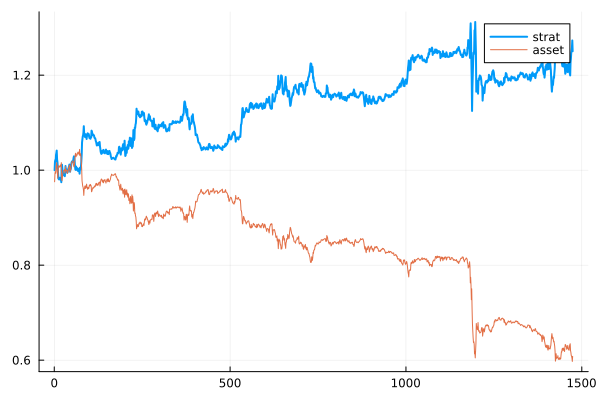

In [47]:
plot(cumprod(1 .+ pnl),w=2,leg=:topright,label="strat")
plot!(cumprod(1 .+ X[obs:end-1]), label="asset")